Dylan Hastings

### 1. k-means on digits

Use K-means clustering on the MNIST dataset (which can be imported with `from sklearn.datasets import load_digits`) to learn to identify the 10 digits in an unsupervised manner.

1. Plot the `cluster_centers_` from a kmeans clustering (which should be shape `(10,64)`) onto a `8x8` grid (hint: use `kmeans.cluster_centers_.reshape`)



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sc
from scipy import stats
import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
sns.set()

In [2]:
from sklearn.datasets import load_digits

In [3]:
digits = load_digits()

In [4]:
digits.data.shape

(1797, 64)

In [5]:
kmeans = KMeans(n_clusters=10, random_state=0)

In [6]:
clusters = kmeans.fit_predict(digits.data)

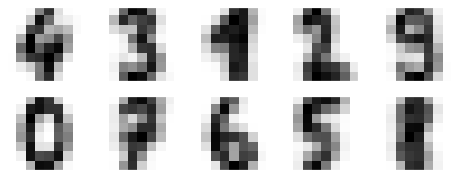

In [7]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

2. Reorganize the clusters so that each of your learned clusters labels overlap with the true label (eg. if the digit 4 has the cluster label 9, you want to remap it to 4). Hint: You can use the statistical mode of your clusters and the real label to match them



In [8]:
from scipy.stats import mode

In [9]:
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

3. Now that your cluster labels are matched to the supervised learning labels, check the classification accuracy of your clustering model (accuracy score and confusion matrix). Give a two paragraph interpretation.



In [10]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7952142459654981

In [11]:
from sklearn.metrics import confusion_matrix

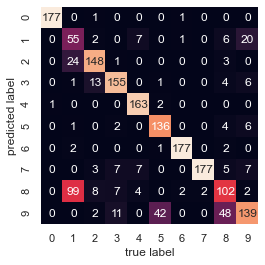

In [12]:
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

With a relatively simple k-means algorithm, we discovered the correct grouping for nearly 80% of the input digits.  The accuracy score function computes the accuracy as the absolute value of the fraction of correct predictions.

Looking at the confusion matrix, the main confusion is between the eights and ones.  Nevertheless, using k-means clustering, we can essentially build a digit classifier without reference to any known labels.

4. Use the Fowlkes-Mallows score to evaluate your clustering against the true labels. Give a two paragraph interpretation comparing to your result in #3.

In [13]:
metrics.fowlkes_mallows_score(digits.target, labels)

0.7041643183491655

The Fowlkes-Mallows score is the geometric mean of the precision and recall:

FMI = TP / sqrt((TP + FP)) * (TP + FN)

Where TP is the number of True Positive (the number of points that belong in the same clusters in both labels_true and labels_pred), FP is the number of False Positive (the number of points that belong in the same clusters in labels true and not in labels_pred) and FN is the number of False Negative (the number of points that belong in the same clusters in labels_pred and not in labels_ture).

The score ranges from 0 to 1, where the higher the score, the better the similarity between the two clusters.  The value of 0.704 is not as high as the accuracy score of 0.795 obtained in #3.

### 2: Image Compression second pass

Use any the clustering algorithms we see to produce what you think is the best image compression ratio that is **visually indistinguishable** from the original image (recall in the lecture the result was very compressed but also much uglier)

Justify your choice and process in 3 paragraphs.

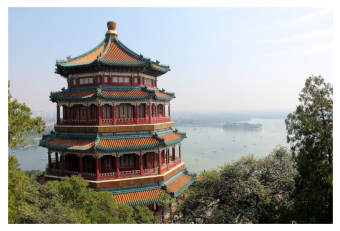

In [14]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

In [15]:
china.shape

(427, 640, 3)

In [16]:
data = china / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

In [17]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

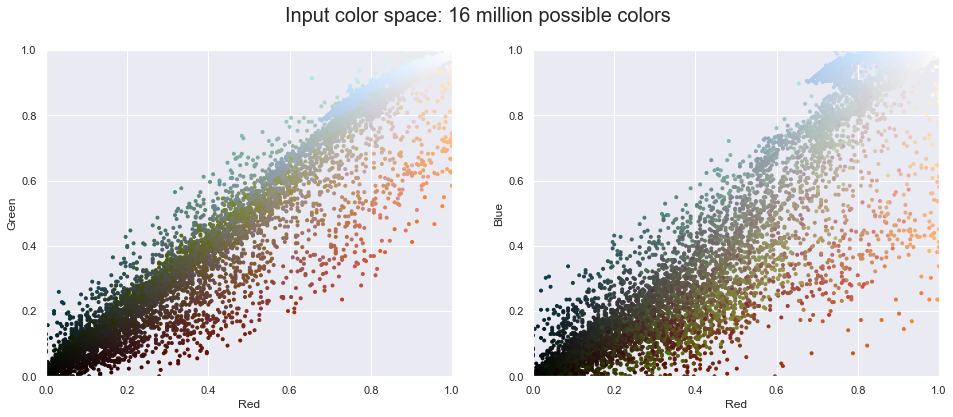

In [18]:
plot_pixels(data, title='Input color space: 16 million possible colors')

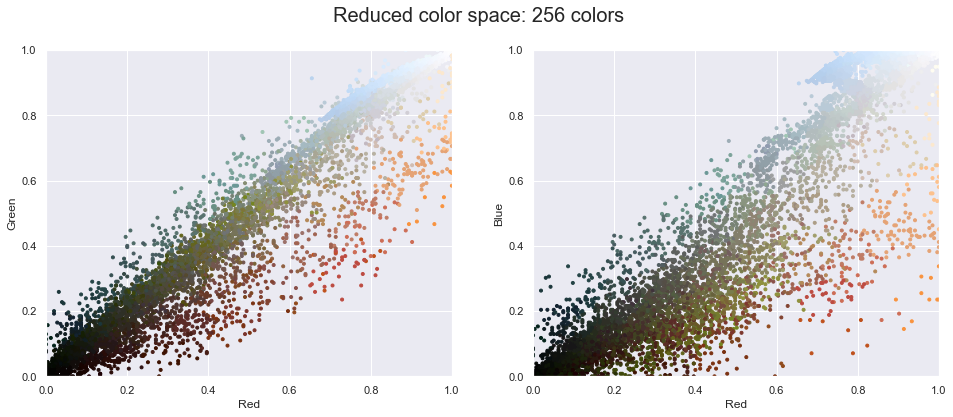

In [34]:
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(256)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 256 colors")

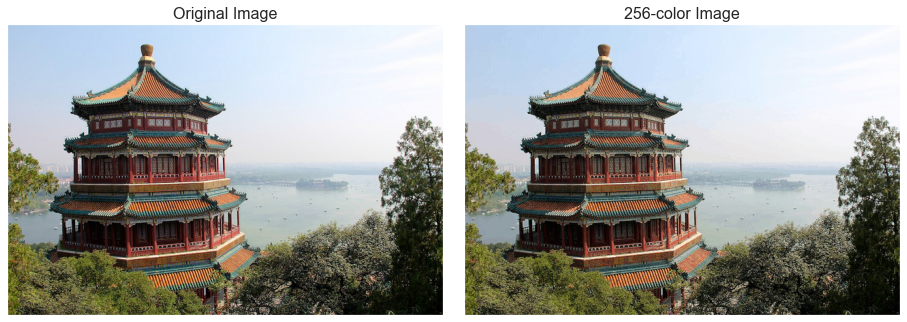

In [35]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('256-color Image', size=16);

In [36]:
16000000/256

62500.0

I started started with the black and white image that was seen in the lecture.  From there, I kept doubling the number of colours until I reached the 256 colors as shown above.  For me, the images are visually indistiguable, yet the image on the right is 62,500 times smaller.

# 3. Clustering on Colleges

This question will use the data from `college.csv`

1. Use clustering with `k=2` on all data except whether the college is private of not. Try to match it best to the private/public college split (hint: don't forget to normalize your features!). Evaluate it in terms of classification metrics and clustering metrics.



In [21]:
df = pd.read_csv('data/college.csv').set_index('Unnamed: 0')

In [22]:
X = df.copy()

In [23]:
kmeans = KMeans(n_clusters=2, random_state=101)

In [24]:
kmeans.fit(X.drop('Private',axis=1))

KMeans(n_clusters=2, random_state=101)

In [25]:
def converter(cluster):
    if cluster=='Yes':
        return 1
    else:
        return 0

In [26]:
X['Cluster'] = X['Private'].apply(converter)
X

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate,Cluster
Unnamed: 0,,,,,,,,,,,,,,,,,,,
Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60,1
Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56,1
Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54,1
Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59,1
Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Worcester State College,No,2197,1515,543,4,26,3089,2029,6797,3900,500,1200,60,60,21.0,14,4469,40,0
Xavier University,Yes,1959,1805,695,24,47,2849,1107,11520,4960,600,1250,73,75,13.3,31,9189,83,1
Xavier University of Louisiana,Yes,2097,1915,695,34,61,2793,166,6900,4200,617,781,67,75,14.4,20,8323,49,1


In [27]:
from sklearn.metrics import confusion_matrix,classification_report

In [28]:
print(confusion_matrix(X['Cluster'],kmeans.labels_))

[[138  74]
 [531  34]]


In [29]:
print(classification_report(X['Cluster'],kmeans.labels_))

              precision    recall  f1-score   support

           0       0.21      0.65      0.31       212
           1       0.31      0.06      0.10       565

    accuracy                           0.22       777
   macro avg       0.26      0.36      0.21       777
weighted avg       0.29      0.22      0.16       777



2. Knowing what you found in `3.1`, find the best overall clustering with the k of your choice. Make an argument and a visualization of the clusters (with two relevant statistics) to demonstrate why you think your clustering is good.

In [49]:
k_values = [2,4,6,8,10,16,32]

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=101)
    kmeans.fit(X.drop('Private',axis=1))
    print(f'k={k}')
    print(classification_report(X['Cluster'],kmeans.labels_))
    print(np.round(metrics.fowlkes_mallows_score(X['Cluster'],kmeans.labels_),5))

k=2
              precision    recall  f1-score   support

           0       0.21      0.65      0.31       212
           1       0.31      0.06      0.10       565

    accuracy                           0.22       777
   macro avg       0.26      0.36      0.21       777
weighted avg       0.29      0.22      0.16       777

0.75181
k=4
              precision    recall  f1-score   support

           0       0.29      0.64      0.40       212
           1       0.09      0.01      0.02       565
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

    accuracy                           0.18       777
   macro avg       0.09      0.16      0.10       777
weighted avg       0.14      0.18      0.12       777

0.56542
k=6
              precision    recall  f1-score   support

           0       0.02      0.02      0.02       212
           1       0.13      0.01      0.01       565
           2       0.00      0.00      0.00    

Looking at the accuracy and the Fowlkes-Mallows score, the best overall clustering seems to be with k=2.